In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import openai
import matplotlib.pyplot as plt
import seaborn as sns
from deap import base, creator, tools, algorithms

In [2]:
# Set your OpenAI API key
openai.api_key = ''

In [3]:
# Step 1: Load the dataset
file_path = '3026NMfixed_UT.csv'
dataset = pd.read_csv(file_path)

# Display the first few rows of the dataset
print(dataset.head())

   Speaker                       utterance  ut
0        2                      Nope. No.   10
1        2                       Yes. No.   10
2        2                          Yeah.   10
3        2                      Movement.    9
4        2  Distance traveling over time.    9


In [4]:
# Function to get GPT-3 embeddings for a given text
def get_gpt3_embeddings(text_list, batch_size=10):
    embeddings = []
    for i in range(0, len(text_list), batch_size):
        batch = text_list[i:i+batch_size]
        response = openai.Embedding.create(model="text-embedding-ada-002", input=batch)
        embeddings.extend([res['embedding'] for res in response['data']])
    return np.array(embeddings)

In [5]:
# Get GPT-3 embeddings for the 'utterance' column
X_text = get_gpt3_embeddings(dataset['utterance'].tolist())

In [6]:
# Step 3: Dimensionality Reduction (Optional but can help with noise)
pca = PCA(n_components=50)
X_reduced = pca.fit_transform(X_text)

In [7]:
# Step 4: Define the Genetic Algorithm

# Remove existing classes to avoid warnings
if 'FitnessMax' in dir(creator):
    del creator.FitnessMax
if 'Individual' in dir(creator):
    del creator.Individual

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("attr_int", np.random.randint, 2, 31)  # Ensure k is at least 2
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_int, n=1)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def evaluate(individual, data):
    k = individual[0]
    if k < 2:
        return -1,
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(data)
    score = silhouette_score(data, labels)
    return score,

toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=2, up=30, indpb=0.2)  # Ensure k is within the valid range
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate, data=X_reduced)

In [8]:
# Genetic Algorithm parameters
population_size = 100
num_generations = 50
mutation_probability = 0.3
crossover_probability = 0.7
elitism_size = 5

In [9]:
# Custom mutation function to avoid invalid ranges
def custom_mutate(individual, low, up, indpb):
    size = len(individual)
    for i in range(size):
        if np.random.rand() < indpb:
            individual[i] = np.random.randint(low, up)
    return individual,

toolbox.register("mutate", custom_mutate, low=2, up=31, indpb=0.2)  # Fix the upper bound

In [10]:
# Custom crossover function to avoid empty range error
def custom_cxTwoPoint(ind1, ind2):
    if len(ind1) > 1 and len(ind2) > 1:
        size = min(len(ind1), len(ind2))
        cxpoint1 = np.random.randint(1, size)
        cxpoint2 = np.random.randint(1, size - 1)
        if cxpoint2 >= cxpoint1:
            cxpoint2 += 1
        ind1[cxpoint1:cxpoint2], ind2[cxpoint1:cxpoint2] = ind2[cxpoint1:cxpoint2], ind1[cxpoint1:cxpoint2]
    return ind1, ind2

toolbox.register("mate", custom_cxTwoPoint)

In [11]:
# Step 5: Run the Genetic Algorithm
population = toolbox.population(n=population_size)
hall_of_fame = tools.HallOfFame(elitism_size)
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

logbook = tools.Logbook()  # Initialize logbook to track statistics
logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the entire population
    fitnesses = list(map(toolbox.evaluate, population))
    for ind, fit in zip(population, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(population), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Select the next generation individuals
        offspring = toolbox.select(population, len(population) - elitism_size)
        # Clone the selected individuals
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if np.random.rand() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if np.random.rand() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Add the best individuals from the previous generation (elitism)
        offspring.extend(list(map(toolbox.clone, halloffame)))

        # Replace the current population with the offspring
        population[:] = offspring

        # Append the current generation statistics to the logbook
        record = stats.compile(population) if stats else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook

In [12]:
# Run the genetic algorithm with elitism
population, logbook = eaSimpleWithElitism(population, toolbox, cxpb=crossover_probability, mutpb=mutation_probability,
                                          ngen=num_generations, stats=stats, halloffame=hall_of_fame, verbose=True)

gen	nevals	avg     	std      	min      	max     
0  	100   	0.111445	0.0205708	0.0714868	0.147458
1  	79    	0.12954 	0.0155596	0.0714868	0.147458
2  	79    	0.140463	0.00784414	0.104418 	0.147458
3  	71    	0.143357	0.0101008 	0.0981587	0.147458
4  	69    	0.145902	0.0075638 	0.0869206	0.147458
5  	74    	0.146011	0.00669228	0.103828 	0.147458
6  	81    	0.1465  	0.00543922	0.0981587	0.147458
7  	72    	0.145437	0.00941704	0.0872857	0.147458
8  	71    	0.146117	0.00657527	0.0981587	0.147458
9  	72    	0.146348	0.00498364	0.110961 	0.147458
10 	69    	0.143097	0.0132244 	0.0869206	0.147458
11 	66    	0.146118	0.00582106	0.102208 	0.147458
12 	71    	0.14488 	0.0102167 	0.0714868	0.147458
13 	73    	0.144521	0.0113629 	0.0714868	0.147458
14 	75    	0.145182	0.00995965	0.0869206	0.147458
15 	72    	0.145752	0.00691385	0.103235 	0.147458
16 	71    	0.144939	0.0089561 	0.0904066	0.147458
17 	71    	0.143921	0.0119598 	0.0872857	0.147458
18 	67    	0.14382 	0.0123829 	0.0714868	0.147458
19 

In [13]:
# Get the best individual and its fitness score
best_individual = hall_of_fame[0]
optimal_k = best_individual[0]
optimal_score = best_individual.fitness.values[0]

print(f"Optimal number of clusters: {optimal_k}")
print(f"Best silhouette score: {optimal_score}")

Optimal number of clusters: 30
Best silhouette score: 0.14745809095012719


In [14]:
# Perform final clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
final_labels = kmeans.fit_predict(X_reduced)

In [15]:
# Display the cluster labels for the first few utterances
dataset['Cluster'] = final_labels
print(dataset.head())

   Speaker                       utterance  ut  Cluster
0        2                      Nope. No.   10       10
1        2                       Yes. No.   10       10
2        2                          Yeah.   10       13
3        2                      Movement.    9        0
4        2  Distance traveling over time.    9        1


In [16]:
# Step 6: Visualize the clusters using t-SNE

# Reduce dimensionality for visualization
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_reduced)

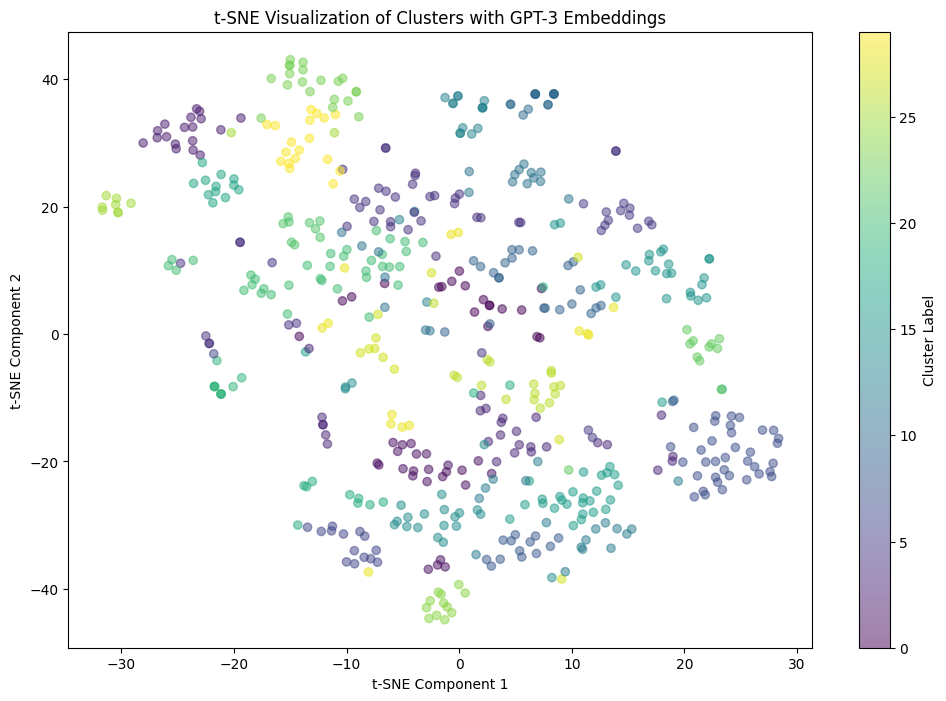

In [17]:
# Plot the clusters
plt.figure(figsize=(12, 8))
scatter = plt.scatter(X_tsne[:, 0], X_tsne[:, 1], c=final_labels, cmap='viridis', alpha=0.5)
plt.title('t-SNE Visualization of Clusters with GPT-3 Embeddings')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.colorbar(scatter, label='Cluster Label')
plt.show()

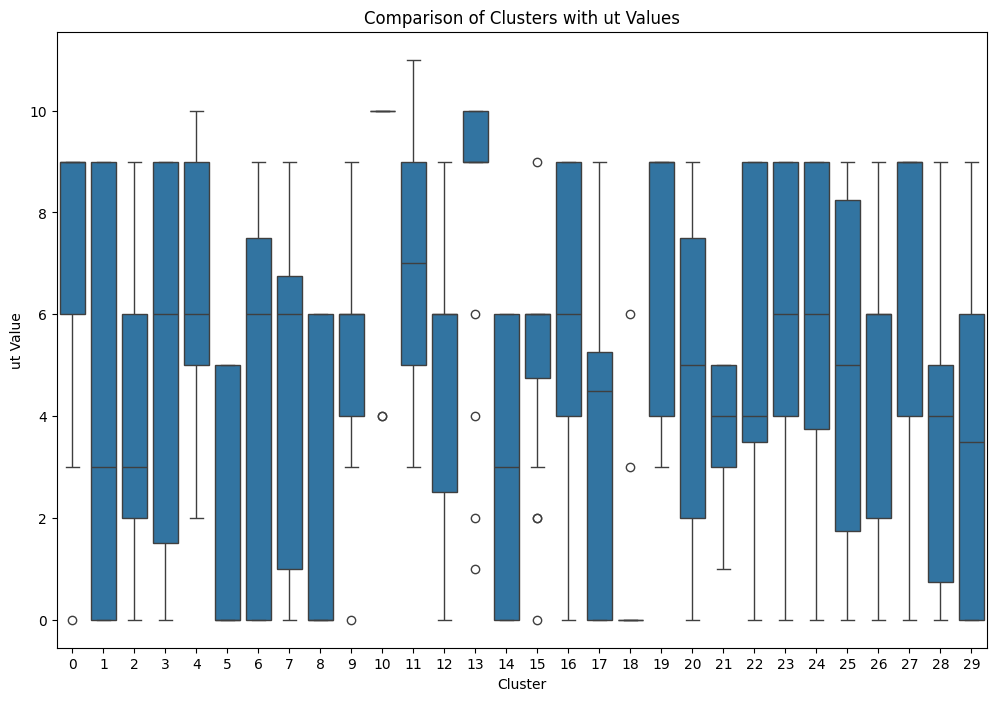

In [18]:
# Step 7: Compare Clusters with 'ut' Values

# Box plot to visualize the distribution of 'ut' values across clusters
plt.figure(figsize=(12, 8))
sns.boxplot(x='Cluster', y='ut', data=dataset)
plt.title('Comparison of Clusters with ut Values')
plt.xlabel('Cluster')
plt.ylabel('ut Value')
plt.show()

In [19]:
# Statistical summary of 'ut' values in each cluster
cluster_summary = dataset.groupby('Cluster')['ut'].describe()
print(cluster_summary)

         count      mean       std  min    25%   50%    75%   max
Cluster                                                          
0         19.0  7.315789  2.829461  0.0   6.00   9.0   9.00   9.0
1         24.0  3.875000  3.745287  0.0   0.00   3.0   9.00   9.0
2         18.0  3.666667  2.970443  0.0   2.00   3.0   6.00   9.0
3         27.0  4.814815  3.616597  0.0   1.50   6.0   9.00   9.0
4         42.0  6.571429  2.380232  2.0   5.00   6.0   9.00  10.0
5         14.0  2.142857  2.567763  0.0   0.00   0.0   5.00   5.0
6         15.0  4.533333  3.700708  0.0   0.00   6.0   7.50   9.0
7         36.0  4.638889  3.415534  0.0   1.00   6.0   6.75   9.0
8         13.0  2.153846  2.794225  0.0   0.00   0.0   6.00   6.0
9         24.0  5.333333  1.992740  0.0   4.00   6.0   6.00   9.0
10        14.0  9.142857  2.178819  4.0  10.00  10.0  10.00  10.0
11        18.0  6.777778  2.624669  3.0   5.00   7.0   9.00  11.0
12        19.0  4.421053  2.714484  0.0   2.50   6.0   6.00   9.0
13        

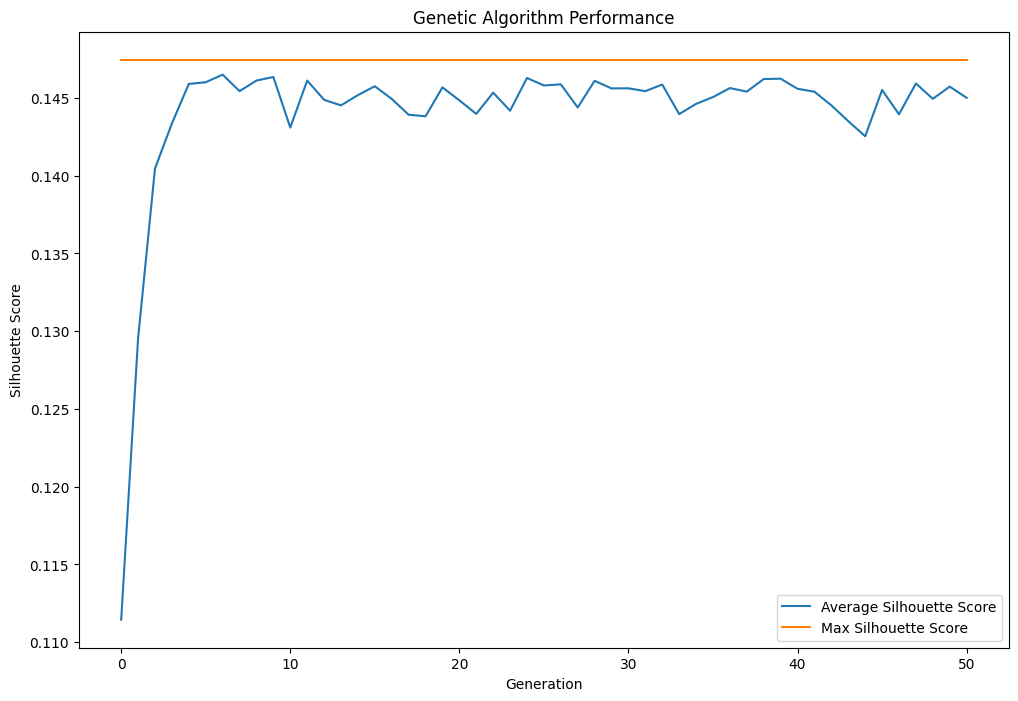

In [20]:
# Step 8: Plot the performance of the genetic algorithm
gen = logbook.select("gen")
avg_fitness = logbook.select("avg")
max_fitness = logbook.select("max")

plt.figure(figsize=(12, 8))
plt.plot(gen, avg_fitness, label='Average Silhouette Score')
plt.plot(gen, max_fitness, label='Max Silhouette Score')
plt.xlabel('Generation')
plt.ylabel('Silhouette Score')
plt.title('Genetic Algorithm Performance')
plt.legend()
plt.show()